In [22]:
from apiclient.discovery import build
from apiclient.errors import HttpError
import numpy as np
from IPython.core.debugger import set_trace
import re
import difflib
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import time
import random
import pickle
from lxml.html import fromstring
from collections import Counter
from requests.packages.urllib3.util import Retry
from requests.adapters import HTTPAdapter
from requests import Session, exceptions
import sys
import pymongo
from pymongo import MongoClient
from newspaper import Article
import json
from string import digits
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
from nltk.stem.porter import *
from collections import Counter 
from nltk.corpus import wordnet # To get words in dictionary with their parts of speech
from nltk.stem import WordNetLemmatizer # lemmatizes word based on it's parts of speech
from nltk.corpus import stopwords 
from textblob import TextBlob
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import cmudict
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from langdetect import detect
from numpy import dot
from numpy.linalg import norm
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
sys.path.append("/Users/rohanramesh/Documents/GitHub/Insight_writers/lib/")
from text_processing import ProcessArticle as pa
import suggestions as s
import networkx as nx

In [ ]:
# Establish connection with database
client = MongoClient()
mydb = client["testinsightdb"]

In [ ]:
# grab config file
# keys[0] apple, keys[1] listen notes
path_teams = '/Users/rohanramesh/Documents/Insight/data_bball_writers/config.txt'
with open(path_teams, 'r') as f:
    tmp = f.readlines()
keys = [i.rstrip() for i in tmp]

In [ ]:
DEVELOPER_KEY = keys[0]
YOUTUBE_API_SERVICE_NAME = "youtube"
YOUTUBE_API_VERSION = "v3"
youtube = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION,developerKey=DEVELOPER_KEY)

In [ ]:
def get_video_id(q, max_results,token, order="relevance", 
                 location=None, location_radius=None):

    search_response = youtube.search().list(
        q=q, type="video", pageToken=token,part="id,snippet", 
        maxResults=max_results, location=location, 
        locationRadius=location_radius, safeSearch = 'strict').execute()
    videoId = []
    title = []
    description = []
    statistics = []
    embed_url = []
    tok = search_response['nextPageToken']

    for search_result in search_response.get("items", []):
        if search_result["id"]["kind"] == "youtube#video":
            title.append(search_result['snippet']['title'])
            videoId.append(search_result['id']['videoId'])
            response = youtube.videos().list(part='statistics, snippet, player', 
                                 id=search_result['id']['videoId']
                                ).execute()
            description.append(response['items'][0]['snippet']['description'])
            statistics.append(response['items'][0]['statistics'])
            embed_url.append(response['items'][0]['player']['embedHtml'])
            
    ydict = {'title':title,'videoId':videoId,
              'description':description,'stats':statistics,
             'embed_url':embed_url}
    return ydict, tok

In [ ]:
# initialize spacy and load team names for named entity recognition
nlp = en_core_web_sm.load()
# team names
path_teams = '/Users/rohanramesh/Documents/GitHub/Insight_writers/DashApp/assets/nba-teams.txt'
with open(path_teams, 'r') as f:
    tmp = f.readlines()
team_names = [i.rstrip() for i in tmp]

def get_search_terms(string=None, team_names=None):
    doc = nlp(string)
    a = [i.text for i in doc.ents if (i.label_ == 'PERSON') | (i.label_ == 'GPE')]
    # iterate through each word in string and compare to team_names if any hits then keep
    if team_names is not None:
        tokens = word_tokenize(string)
        for i in tokens:
            if not difflib.get_close_matches(i,team_names, n=1):
                continue
            else:
                m = difflib.get_close_matches(i,team_names, n=1)[0]
            a.append(m)
    # now turn to normal string
    input_search = ['']
    for i in a:
        input_search[0] = input_search[0] + i + ' '
    return input_search[0]

def parse_iframe_html(input_vec):
    output_url = []
    for i in input_vec:
        idx = i.index('src="')
        tmpR = i[idx+5:]
        idx2 = tmpR.index('"')
        output_url.append(tmpR[:idx2])
    return output_url
        


In [9]:
# for old word2vec model
kv = gensim.models.KeyedVectors.load(
    "/Users/rohanramesh/Documents/Insight/data_bball_writers/word2vec_model_kv.kv", mmap='r')
# load word2vec df for comparisons
w2v_df2 = pd.read_pickle('/Users/rohanramesh/Documents/Insight/data_bball_writers/word2vec_trained.pickle')

In [ ]:
# load dataframe for writer feature space
writer_features = pd.read_pickle('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_features_USE.pickle')


# load word2vec model
kv = gensim.models.KeyedVectors.load(
    "/Users/rohanramesh/Documents/Insight/data_bball_writers/word2vec_model_kv.kv", mmap='r')
# load word2vec df for comparisons
w2v_df = pd.read_pickle('/Users/rohanramesh/Documents/Insight/data_bball_writers/word2vec_trained.pickle')

# client = MongoClient()
# mydb = client["testinsightdb"]

# for logo
# image_filename = '/Users/rohanramesh/Documents/GitHub/Insight_writers/DashApp/assets/favicon.ico' # replace with your own image
# encoded_image = base64.b64encode(open(image_filename, 'rb').read())

# for youtube suggestions
# team names
path_teams = '/Users/rohanramesh/Documents/GitHub/Insight_writers/DashApp/assets/nba-teams.txt'
with open(path_teams, 'r') as f:
    tmp = f.readlines()
team_names = [i.rstrip() for i in tmp]
nlp = en_core_web_sm.load()

# config file
path_teams = '/Users/rohanramesh/Documents/Insight/data_bball_writers/config.txt'
with open(path_teams, 'r') as f:
    tmp = f.readlines()
keys = [i.rstrip() for i in tmp]

In [1]:
# url = 'http://www.espn.com/nba/story/_/id/24796800/los-angeles-lakers-hold-first-practice-lebron-james'
url = 'http://www.espn.com/fantasy/basketball/story/_/id/24731308/fantasy-basketball-fantasy-basketball-sleepers-breakouts-busts-2018-19'
article, lem_txt = s.grab_article(url)
author_sugg = s.give_suggestion_featurespace_single_article(writer_features, txtstr=article.text)
article_sugg = s.recommend_article_content(kv, w2v_df, lem_text=lem_txt)
search_string = s.get_search_terms(article.title, team_names)
print(search_string)
# youtube_ouput, b = get_video_id(search_string, 3, None)
# urls_to_pass = s.parse_iframe_html(embed_url) 


NameError: name 's' is not defined

In [26]:
a = kv['lebron'] + kv['history']
lebron_history = kv.similar_by_vector(a)
words_associated = [lebron_history[i][0] for i in range(2,len(lebron_history))]
strength_words_associated = [lebron_history[i][1] for i in range(2,len(lebron_history))]

In [31]:
# make a graph for each connection with lebron and history
G = nx.DiGraph()
G.add_nodes_from(words_associated)
# G.add_nodes_from('lebron')
for i in range(0,len(strength_words_associated)):
    G.add_edge('lebron', words_associated[i], weight=strength_words_associated[i])


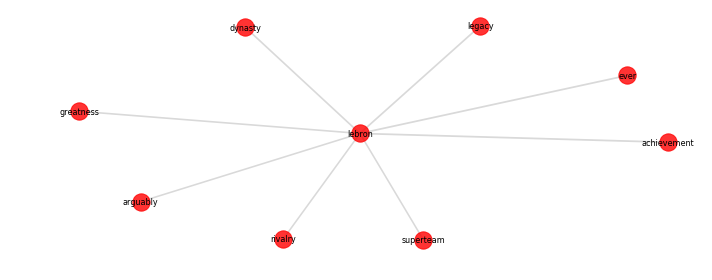

In [32]:
pos = nx.kamada_kawai_layout(G)
#     pos=nx.spring_layout(G, iterations=500)
    # pos=nx.circular_layout(G)
cm = plt.get_cmap('inferno_r', 7) # 7 bc of the 5 positions and no black
unique_pos = ['PG', 'SG', 'SF', 'PF', 'C']
curr_positions = nx.get_node_attributes(G, 'pos')
nodecolors = [cm.colors[j] for i in curr_positions for j in range(0,len(unique_pos))
              if curr_positions[i] == unique_pos[j]]
edge_labels=dict([((u, v, ), round(d['weight']))
                 for u, v, d in G.edges(data=True)])
# for the node size
node_size_use = nx.get_node_attributes(G, 'ppg')
node_array = [node_size_use[i]*25 for i in list(node_size_use)]
labels_use = {}
for i in G.nodes():
    labels_use[i] = i
# print(edge_labels)
edgewidth = [d['weight']*4 for (u, v, d) in G.edges(data=True)]
plt.figure(figsize=(10, 4))
# # we can now added edge thickness and edge color
nx.draw_networkx_nodes(G, pos=pos, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=edgewidth, alpha=0.15, arrowstyle='simple',
                       arrowsize=5, arrows=False, edge_cmap=plt.cm.Greys)
nx.draw_networkx_labels(G, pos, labels_use, font_size=8)
plt.axis('off')
plt.tight_layout()